# Imports

In [2]:
!pip install langdetect

In [109]:
import re
import spacy
import pickle
import statistics
import joblib
import requests
import uuid
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from langdetect import detect
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from nltk import download, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, RSLPStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud

import warnings


warnings.filterwarnings("ignore", category=UserWarning)


# Data Import

In [7]:
airbnb_df_train = pd.read_excel("/content/drive/MyDrive/Uni/Text Mining/train.xlsx")
airbnb_df_test = pd.read_excel("/content/drive/MyDrive/Uni/Text Mining/test.xlsx")
airbnb_df_train_reviews = pd.read_excel("/content/drive/MyDrive/Uni/Text Mining/train_reviews.xlsx")
airbnb_df_test_reviews = pd.read_excel("/content/drive/MyDrive/Uni/Text Mining/test_reviews.xlsx")
pd.options.display.max_colwidth = 50

# First Data Exploration

In [8]:
airbnb_df_train.shape

(12496, 4)

In [9]:
airbnb_df_train_reviews.shape

(721402, 2)

In [10]:
airbnb_df_train.head()

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [11]:
airbnb_df_train_reviews.head()

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [12]:
airbnb_df_test.head()

,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
3,4,Charming Apartment Close to the Bay of Cascais...,:)
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


In [13]:
airbnb_df_test_reviews.head()

,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...
3,1,We've been in Lisbon in march 2013 (3 adults a...
4,1,Our host Antonio was very helpful with informa...


# Exploratory Data Analysis

## Language Detection

We use the `langdetect` library to detect the language used in comments. The function returns the language of the text or "Unknown" if it cannot be detected.

In [14]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'Unknown'

### Language detection for reviews

In [15]:
airbnb_df_train_reviews["lang_comments"] = airbnb_df_train_reviews["comments"].apply(detect_language)

In [16]:
airbnb_df_train_reviews.head()

,index,comments,lang_comments
0,1,this is a very cozy and comfortable house to s...,en
1,1,good<br/>,cy
2,1,"My first hostel experience, and all I have to ...",en
3,1,Das Hostel war neu und deshalb funktionierte a...,de
4,1,"It was fine for a dorm, but I think for the pe...",en


In [17]:
airbnb_df_train_reviews['lang_comments'].nunique()

46

In [18]:
airbnb_df_train_reviews['lang_comments'].value_counts()

en         461823
fr         107032
pt          45677
es          38667
de          28558
it          11435
nl           7409
ru           3015
ko           2916
zh-cn        1959
Unknown      1817
ro           1543
pl           1233
ca           1091
da            891
sv            786
af            663
no            598
so            555
fi            420
cs            391
id            324
tl            292
hu            285
cy            239
ja            224
he            177
zh-tw         174
hr            160
tr            139
sw            136
lt            133
sk            128
el            116
uk             84
vi             80
sl             77
et             58
bg             28
lv             22
ar             20
sq             15
mk              7
th              2
ne              2
ur              1
Name: lang_comments, dtype: int64

### Language detection for desc/host_about

In [19]:
airbnb_df_train["lang_desc"] = airbnb_df_train["description"].apply(detect_language)

In [20]:
airbnb_df_train["lang_host"] = airbnb_df_train["host_about"].apply(detect_language)

In [21]:
airbnb_df_train.head()

,index,description,host_about,unlisted,lang_desc,lang_host
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,pt,en
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr


In [22]:
airbnb_df_train["lang_desc"].nunique()

14

In [23]:
airbnb_df_train["lang_desc"].value_counts()

en       10203
pt        1843
fr         153
da         126
de          87
es          48
sv           8
ca           7
no           5
it           4
zh-cn        4
nl           4
ru           3
pl           1
Name: lang_desc, dtype: int64

In [24]:
airbnb_df_train["lang_host"].nunique()

33

In [25]:
airbnb_df_train["lang_host"].value_counts()

en         8902
pt         2522
fr          273
es          177
Unknown     131
de          108
it           81
ca           69
zh-cn        55
so           35
nl           22
fi           17
no           16
af           13
sk            8
tl            7
id            6
ro            6
ru            6
et            5
sw            5
sv            5
lt            4
da            4
zh-tw         4
tr            4
hu            3
ko            2
sl            2
he            1
vi            1
hr            1
cs            1
Name: lang_host, dtype: int64

We note that the language identified in the "lang_desc" and "lang_host" columns may be different (e.g., one Portuguese and the other English).
This may be because listing descriptions and host information could be written in different languages depending on host or guest preferences.

## Graphical Exploration

In [28]:
def plot_language_distribution(df, column):
    lang_counts = df[column].value_counts()

    # Sort the language counts in descending order
    sorted_lang_counts = lang_counts.sort_values(ascending=False)

    # Take the top 5 languages
    top_lang_counts = sorted_lang_counts[:5]

    # Calculate the total percentage of the top 5 languages
    total_percentage = top_lang_counts.sum() / len(df) * 100

    # Calculate the percentages for the top 5 languages
    top_lang_percentages = top_lang_counts / len(df) * 100

    # Calculate the percentage for other languages
    other_percentage = 100 - total_percentage

    # Create a list of labels for the top 5 languages and 'Other'
    labels = list(top_lang_counts.index) + ['Other']

    # Create a list of percentages for the top 5 languages and 'Other'
    percentages = list(top_lang_percentages) + [other_percentage]

    # Create the pie chart with the top 5 languages and 'Other'
    plt.figure(figsize=(7, 5))
    patches, _, _ = plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=90)

    # Show only the percentage and label for the top 5 languages
    for i, p in enumerate(patches):
        if i >= 5:
            p.set_label('')

    plt.title(f"Distribution of languages in {column} (Top 5)")
    plt.show()

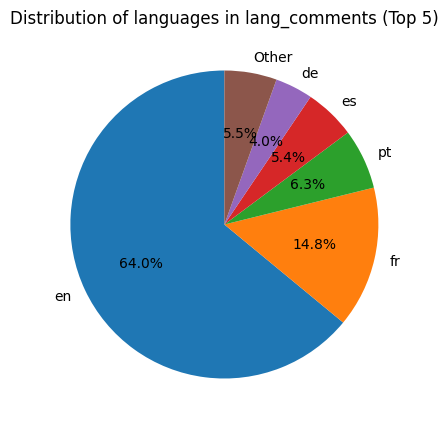

In [29]:
plot_language_distribution(airbnb_df_train_reviews, "lang_comments")

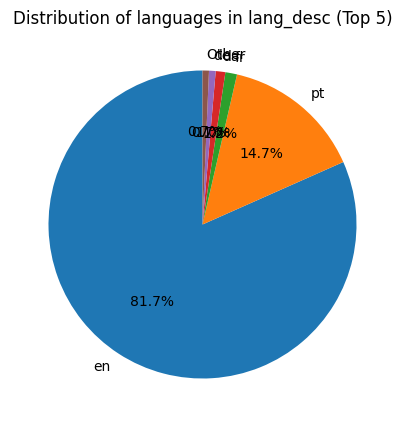

In [30]:
plot_language_distribution(airbnb_df_train, "lang_desc")

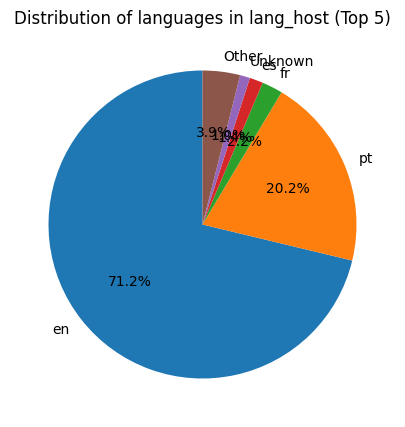

In [31]:
plot_language_distribution(airbnb_df_train, "lang_host")

In [32]:
# Calculate the length of comments
comment_lengths = airbnb_df_train_reviews['comments'].str.len()

# Check the descriptive statistics
comment_lengths.describe()

count    721401.000000
mean        280.584822
std         267.108024
min           1.000000
25%         108.000000
50%         211.000000
75%         367.000000
max        6403.000000
Name: comments, dtype: float64

- Count: 721,397 comments were analyzed.
- Mean: the average length of comments is about 280.59 characters.
- Standard deviation: the standard deviation of comment length is about 267.11, indicating the dispersion of data points around the mean.
- Minimum: the shortest comment has a length of 1 character.
- 25th percentile: the top 25% of comments have a length of 108 characters or less.
- Median (50th percentile): 50% of comments have a length of 211 characters or less.
- 75th percentile: 75% of comments have a length of 367 characters or less.
- Maximum: the longest comment has a length of 6403 characters.

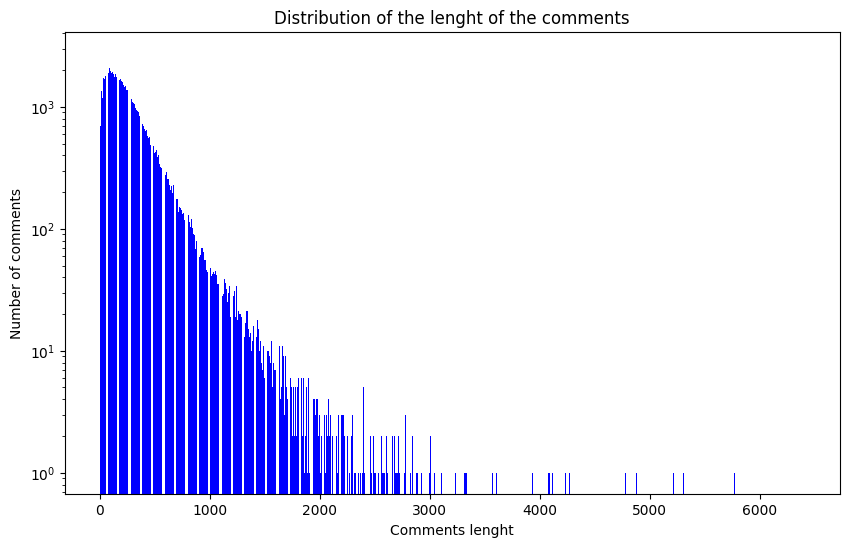

In [33]:
# Calculate the number of comments for each lenght
comment_length_counts = comment_lengths.value_counts().sort_index()

# Barplot
plt.figure(figsize=(10, 6))
plt.bar(comment_length_counts.index, comment_length_counts.values, color='blue')

# Labels
plt.xlabel('Comments lenght')
plt.ylabel('Number of comments')
plt.title('Distribution of the lenght of the comments')
plt.yscale('log')

plt.show()

In [34]:
# Check the null values in the comments
airbnb_df_train_reviews['comments'].isnull().sum()

0

In [35]:
# Check which comments are null
null_comments = airbnb_df_train_reviews[airbnb_df_train_reviews['comments'].isnull()]

for i in null_comments['comments']:
    print(i)

In [36]:
# Filter comments with length = 1
comments_length_1 = airbnb_df_train_reviews[airbnb_df_train_reviews['comments'].str.len() == 1]

for comment in comments_length_1['comments']:
    print(comment)

.
I
👍
.
q
👍
-
.
.
-
.
.
.
O
.
💚
👍
ø
.
.
.
.
A
👍
.
J
.
G
.
-
.
.
😊
.
K
.
👌
å
👍
.
.
.
.
K
👍
-
/
👍
L
r
.
🙂
!
👍
.
-
.
.
…
🔝
👍
.
.
.
A
.
-
-
.
-
.
.
-
.
…
.
.
x
-
.
´
q
A
👍
.
E
.
.
👌
.
-
K
.
.
.
.
,
.
.
.
.
X
.
👍
.
.
.
I
.
.
.
D
n
👍
.
.
-
.
.
A
O
.
.
👌
!
.
.
.
C
.
.
-
.
.
S
X
.
.
.
.
.
🔝
-
.
.
1
X
/
.
.
.
.
.
.
N
E
-
-
.
😉
/
X
X
👍
+
.
.
-
.
.
-
N
Z
.
-
.
-
.
I
.
.
.
.
-
.
1
.
.
E
.
.
M
K
.
.
•
-
.
.
.
.
X
.
👍
A
.
.
.
.
C
.
/
.
-
.
.
-
.
.
…
.
.
-
-
-
.
x
_
.
.
.
.
.
v
.
.
.
B
-
-
.
.
.
.
👍
-
.
,
.
P
.
.
👍
.
.
.
👍
-
.
.
.
.
-
.
.
‘
T
B
.
.
.
.
.
X
.
🙏
.
.
.
.
.
.
T
.
A
-
.
.
.
.
.
.
.
.
-
.
.
.
.
.
-
.
A
.
👍
x
.
G
.
.
👌
😘
.
.
.
.
a
X
.
.
.
.
😊
.
-
.
?
.
.
.
.
.
-
.
.
.
.
.
-
.
.
.
.
.
👍
✨
.
.
.
-
0
.
.
.
.
.
v
.
.
.
.
.
👍
无
.
😀
.
.
.
.
😊
n
.
.
👍
/
B
.
.
.
+
.
-
.
💗
A
.
.
.
B
.
🤗
-
.
.
.
v
.
X
.
g
.
S
N
.
.
.
.
.
.
.
A
.
.
A
.
.
.
A
I
.
.
O
👍
.
🤨
.
…
.
-
Q
.
C
.
.
.
.
.
👌
…
👍
.
-
/
-
.
.
.
i
.
.
.
.
.
.
-
.
M
.
X
9
.
.
,
.
-
👍
.
A
.
.
😊
.
a
a
E
X
.
.
X
-
.
.
.
.
.
!
.
.
.
.
.
.
U
.
.
.
9
…
.


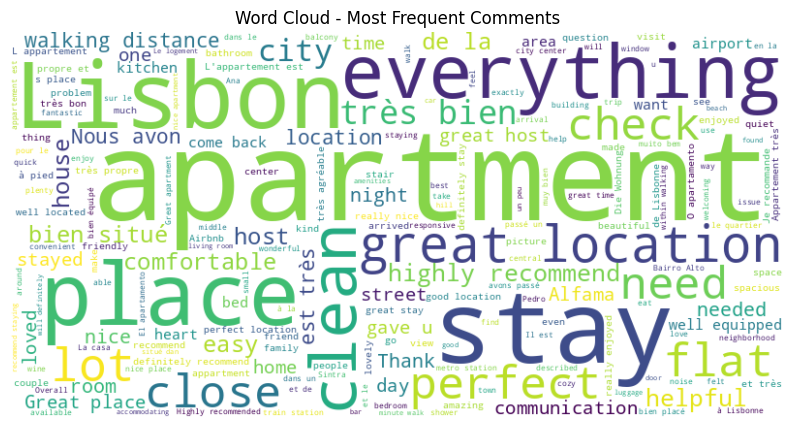

In [59]:
# Remove HTML tags and special characters from comments using regex
cleaned_comments = airbnb_df_train_reviews['comments'].astype(str).apply(lambda x: re.sub('<.*?>|_x000D_', '', x))

# Convert the cleaned comments to a single string
all_comments = ' '.join(cleaned_comments)

# Create the Wordcloud
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

# Show the wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Most Frequent Comments')
plt.show()


In [37]:
#airbnb_df_train.to_csv("/content/drive/MyDrive/Uni/Text Mining/airbnb_df_train_detected.csv")

In [38]:
#airbnb_df_train_reviews.to_csv("/content/drive/MyDrive/Uni/Text Mining/airbnb_df_train_reviews_detected.csv")

# First Approach - TF - IDF with Multimodel for 3 main languages

## Import detected data

In [ ]:
#df_train_detected = pd.read_csv("/content/drive/MyDrive/Uni/Text Mining/airbnb_df_train_detected.csv", index_col="index",).drop("Unnamed: 0",axis=1)
#df_train_reviews_detected = pd.read_csv("/content/drive/MyDrive/Uni/Text Mining/airbnb_df_train_reviews_detected.csv", index_col="index").drop("Unnamed: 0",axis=1)

## Count number of different Languages

In [40]:
def create_df(df, df_review, language):

    columns_to_drop = ['lang_desc', 'lang_host']

    df = df[(df['lang_desc'] == language) & (df['lang_host'] == language)]
    df_review = df_review[df_review['lang_comments'] == language]
    grouped_reviews = df_review.groupby('index')['comments'].apply(lambda x: ''.join(str(x))).reset_index()
    merged_df = pd.merge(df, grouped_reviews, on='index', how='left')
    merged_df = merged_df.drop(columns=columns_to_drop)
    merged_df = merged_df[["index",	"description", "host_about", "comments", "unlisted"]]

    return merged_df

## join all English host_about/desc with English comments

In [60]:
merged_df_english = create_df(airbnb_df_train, airbnb_df_train_reviews, "en")

## Preprocessing English

In [61]:
def preprocessing_eng(row, tokenize, stop, lemmatize, stemmertize):
    updates = []

    for j in tqdm(row):

        text = j

        #LOWERCASE TEXT
        text = str(text).lower()

        # REMOVE NUMERICAL DATA and PUNCTUATION
        # Also weirde words that came from the concatenation
        text = re.sub('<[^>]+>', ' ', text)
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub(r'\b(dtype|object|name)\b', '', text)



        if tokenize:
            tokens = word_tokenize(text)
            text = " ".join(tokens)

        #REMOVE STOPWORDS
        if stop:
            stop_eng = set(stopwords.words('english'))
            text = " ".join([word for word in text.split() if word not in stop_eng])

        #Lemmatize
        if lemmatize:
            lemma_eng = WordNetLemmatizer()
            text = " ".join(lemma_eng.lemmatize(word) for word in text.split())


        #Stemming
        if stemmertize:
            stemmer_eng = SnowballStemmer('english')
            text = " ".join(stemmer_eng.stem(word) for word in text.split())

        updates.append(text)

    return updates

In [62]:
download('wordnet')
download('stopwords')
download('punkt')
columns_to_apply = ['description', 'host_about', 'comments']
merged_df_english[columns_to_apply] = merged_df_english[columns_to_apply].astype(str).apply(lambda row: preprocessing_eng(row=row,
                                                                                                                        tokenize=True,
                                                                                                                        stop=True,
                                                                                                                        lemmatize = True,
                                                                                                                        stemmertize = False
                                                                                                                        )
                                                                                            )

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 8198/8198 [00:08<00:00, 963.71it/s]


In [63]:
#merged_df_english.to_csv("./3.data_train/merged_df_english.csv")

In [64]:
#merged_df_english = pd.read_csv("./3.data_train/merged_df_english.csv").drop(["Unnamed: 0", "index"],axis=1)

In [65]:
merged_df_english

,index,description,host_about,comments,unlisted
0,3,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,nan,1
1,6,important response covid property extended cle...,hi homing company develops activity tourism pr...,nan,0
2,7,home rent traveling perfect vacation without c...,globe trotter portuguese nationality german fa...,nan,1
3,8,find tranquility meticulously curated lifestyl...,travel lot love x originally israel currently ...,shani helpful throughout process accommodation...,0
4,9,charming apartment one bedroom double bed doub...,isabel helder portuguese parent three wonderfu...,great little space lovely host clean w comfort...,0
...,...,...,...,...,...
8193,12489,feel home wherever choose live blueground love...,blueground global proptech company several tho...,nan,1
8194,12492,cat bairro alto cozy apartment lisbon city cen...,travelling one favorite hobby already visited ...,happy find place com great stay lisbon apartme...,0
8195,12493,beautifully located heart lisbon historic cent...,founded travel enthusiast like bnbird want con...,nice place nice location easy communication lo...,0
8196,12494,enjoy breakfast sleek kitchen freestanding kno...,portugal love dance travel x pleasure welcome ...,lovely stay lisbon apartm liliana apartment be...,0


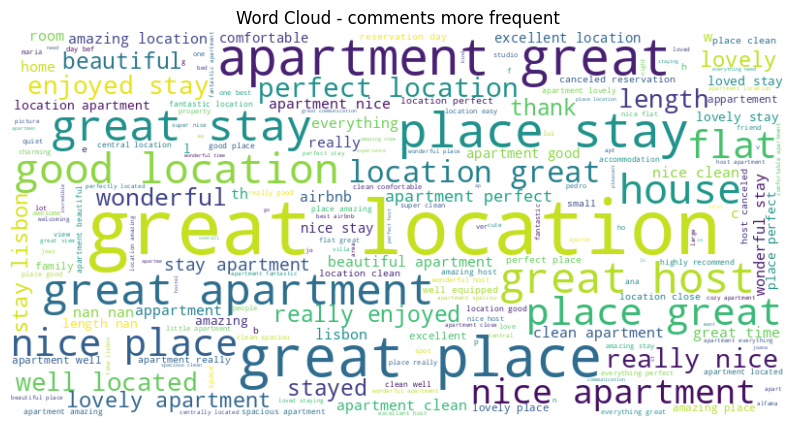

In [66]:
# Merge all the comments
all_comments = ' '.join(merged_df_english['comments'])

# Create the Wordcloud
wordcloud_en = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

# Show the wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_en, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - comments more frequent')
plt.show()

## join all French host_about/desc with French comments

In [68]:
merged_df_french = create_df(airbnb_df_train, airbnb_df_train_reviews, "fr")

In [69]:
merged_df_french

,index,description,host_about,comments,unlisted
0,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,50 Un très bel appartement avec une magnifi...,0
1,189,"Hostel dans maison de ville , location possibl...",Maison typique avec trois chambres individuell...,NaN,0
2,192,"Appartement très chaleureux, avec beaucoup de ...","Je suis teresa, novice dans le domaines de la ...","8931 Appartement spacieux et propre, situé ...",0
3,301,Chambre double tout confort dans grande maison...,Couple de français installé au Portugal où nou...,16068 Tout d’abord une très belle propriété...,0
4,329,Situé au pied du Panthéon dans le quartier de ...,Romain et moi sommes un couple qui sommes tomb...,17946 Appartement très bien situé dans le q...,1
...,...,...,...,...,...
99,11799,Appartement de 2 pièces entièrement rénové se ...,"Bonjour, je m’appelle Leo, un français d’origi...",683686 Accueil très chaleureux de Pedro (1 ...,0
100,11878,Chambre sexy in-love. Chambre avec de nombreux...,"Avec mon mari Dominique, nous vous proposons à...",NaN,0
101,11997,Ce logement affiche un style résolument unique...,j'aime les paisagem la montagne et tout qui c'...,NaN,1
102,12210,Jolie maison typique portugaise et entièrement...,Christophe & Lila marié . Trois enfants,706500 Nous avons passé un très bon dans ce...,0


In [82]:
!pip3 install -U spacy
!python3 -m spacy download fr_core_news_md

In [80]:
def preprocessing_fr(row, tokenize, stop, lemmatize, stemmertize):
    updates = []

    for j in tqdm(row):

        text = j

        #LOWERCASE TEXT
        text = str(text).lower()

        # REMOVE NUMERICAL DATA and PUNCTUATION
        # Also weirde words that came from the concatenation
        text = re.sub('<[^>]+>', ' ', text)
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub(r'\b(dtype|object|name)\b', '', text)

        if tokenize:
            tokens = word_tokenize(text, language="french")
            text = " ".join(tokens)

        #REMOVE STOPWORDS
        if stop:
            stop_fr = set(stopwords.words('french'))
            text = " ".join([word for word in text.split() if word not in stop_fr])


        #Lemmatize
        if lemmatize:
            lemma_fr = spacy.load("fr_core_news_md")
            doc = lemma_fr(text)
            #for word in doc:
            text = " ".join(i.lemma_ for i in doc)

        #Stemming
        if stemmertize:
            stemmer_fr = SnowballStemmer('french')
            stem_doc = stemmer_fr(text)
            for word in stem_doc:
                text = " ".join(stemmer_fr.stem(word) for word in text.split())

        updates.append(text)

    return updates

In [81]:
download('wordnet')
download('stopwords')
columns_to_apply = ['description', 'host_about', 'comments']
merged_df_french[columns_to_apply] = merged_df_french[columns_to_apply].astype(str).apply(lambda x: preprocessing_fr(row=x,
                                                                                                                     tokenize=True,
                                                                                                                     stop=True,
                                                                                                                     lemmatize = True,
                                                                                                                     stemmertize = False
                                                                                                                    )
                                                                                         )

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 104/104 [04:21<00:00,  2.52s/it]


In [ ]:
#merged_df_french.to_csv("./3.data_train/merged_df_french.csv")

In [ ]:
#merged_df_french = pd.read_csv("./3.data_train/merged_df_french.csv").drop(["Unnamed: 0", "index"],axis=1)

In [83]:
merged_df_french

,index,description,host_about,comments,unlisted
0,5,joli appartement bordure mer min avoir pied pl...,famille deux enfant an habit pendant plusieurs...,tr bel appartement magnifique voir appartement...,0
1,189,hostel maison ville location possible chambre ...,maison typique trois chambre individuel r serv...,nan,0
2,192,appartement tr chaleureux beaucoup luminosit l...,teresa novice domaine location esp r apparteme...,appartement spacieux propre situ quelqu logeme...,0
3,301,chambre double tout confort grand maison terra...,couple fran ais install portugal o cr maison h...,tout abord tr bel propri,0
4,329,situ pied panth quartier alfamer venir journer...,romain couple tomb sou charm colmar lisbonn e ...,appartement tr bien situ quartier appartement ...,1
...,...,...,...,...,...
99,11799,appartement pi enti rement r nov situer quarti...,bonjour appeler leo fran ais origine chinois m...,accueil tr chaleureux pedro ami leo excellent ...,0
100,11878,chambre sexy in lover chambre nombreux miroir ...,mari dominiqu proposer deux capital escapade r...,nan,0
101,11997,logement affiche style r solument unique magni...,aimer paisagem montagne tout loisir,nan,1
102,12210,joli maison typique portugais enti rement cl t...,christophe lila mari trois enfant,pass tr bon ce joli,0


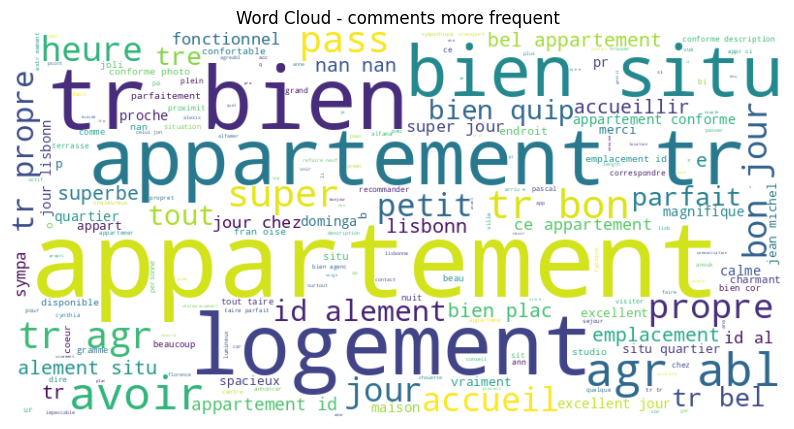

In [84]:
# Merge all the comments
all_comments = ' '.join(merged_df_french['comments'])

# Create the Wordcloud
wordcloud_en = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

# Show the wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_en, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - comments more frequent')
plt.show()

## join all Portuguese host_about/desc with Portuguese comments'

In [86]:
merged_df_pt = create_df(airbnb_df_train, airbnb_df_train_reviews, "pt")

In [87]:
merged_df_pt

,index,description,host_about,comments,unlisted
0,13,O proprietário recebe os hospedes pessoalmente...,"Faço questão de receber os hospedes, para que ...",NaN,0
1,34,Simplifique neste espaço tranquilo e de locali...,"Ola sou Carla, tenho prazer em recebê-los em m...",NaN,1
2,64,"Apartamento composto por uma suite, sala de es...",Apaixonada por Portugal!,NaN,1
3,67,O apartamento está decorado com extremo bom go...,Sou uma pessoa otimista que vive a vida com a ...,NaN,0
4,87,"Óptimo espaço exterior, ideal para quem gosta ...","O meu nome é Cátia, nasci e cresci em Sintra, ...",NaN,1
...,...,...,...,...,...
1089,12457,Casa aconchegante familiar <br />Com ótimas co...,Boa pessoa,"719870 Excelente localização, boas áreas, e...",0
1090,12461,Bem vindo a Lisboa!<br />Este charmoso apartam...,Tenho 38 anos e sou Assistente social de forma...,719920 Excelente apartamento. Um agradecime...,0
1091,12470,"Apartamento para 6 pessoas com 2 quartos, sala...","Chamo-me Margarida. Gosto do mar, praia, do so...",720205 quem quiser passar uns dias num siti...,0
1092,12476,"Apartamento numa zona muito calma de Lisboa, m...","O apartamento é muito, muito simples, mas tem ...",NaN,0


## Preprocessing Portuguese

In [91]:
!python -m spacy download pt_core_news_sm

2023-06-18 18:45:33.490235: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 69.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [98]:
def preprocessing_pt(row, tokenize, stop, lemmatize, stemmertize):
    updates = []

    for j in tqdm(row):

        text = j

        #LOWERCASE TEXT
        text = str(text).lower()

        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub("br", "", text)
        text = re.sub(r'\b(dtype|object|name)\b', '', text)

        if tokenize:
            tokens = word_tokenize(text, language="portuguese")
            text = " ".join(tokens)

        #REMOVE STOPWORDS
        if stop:
            stop_pt = set(stopwords.words('portuguese'))
            text = " ".join([word for word in text.split() if word not in stop_pt])

        #Lemmatize
        if lemmatize:
            lemma_pt = spacy.load("pt_core_news_sm")
            doc = lemma_pt(text)
            text = " ".join(i.lemma_ for i in doc)

        #Stemming
        if stemmertize:
            stemmer_pt = RSLPStemmer()
            stem_doc = stemmer_pt(text)
            for word in stem_doc:
                text = " ".join(stemmer_pt.stem(word) for word in text.split())

        updates.append(text)

    return updates

In [99]:
download('wordnet')
download('stopwords')
columns_to_apply = ['description', 'host_about', 'comments']
merged_df_pt[columns_to_apply] = merged_df_pt[columns_to_apply].astype(str).apply(lambda row: preprocessing_pt(row=row,
                                                                                                             tokenize=True,
                                                                                                             stop=True,
                                                                                                             lemmatize = True,
                                                                                                             stemmertize = False
                                                                                                            )
                                                                                )

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 1094/1094 [10:23<00:00,  1.76it/s]


In [94]:
#merged_df_pt.to_csv("./3.data_train/merged_df_pt.csv")

In [95]:
#merged_df_pt = pd.read_csv("./3.data_train/merged_df_pt.csv").drop(["Unnamed: 0","index"],axis=1)

In [100]:
merged_df_pt

,index,description,host_about,comments,unlisted
0,13,propriet rio receber hospede pessoalmente hosp...,fa quest receber hospede sintar casa,nan,0
1,34,simplifique Espa tranquilo localizar central q...,olar carlar prazer receb los alojamentar bem v...,nan,1
2,64,apartamento compor suite sala tv kitchenette a...,apaixonar Portugal,nan,1
3,67,apartamento est decorar extremo bom gosto comb...,pessoa otimista viver vida alegrio entusiasmo ...,nan,0
4,87,ptimo espa exterior ideal gostar desfrutar ar ...,nome c tia nascer crescir sintro Vila cora apa...,nan,1
...,...,...,...,...,...
1089,12457,casa aconchegante familiar timar condi es pert...,bom pessoa,excelente localizar bom reo excelente i amei c...,0
1090,12461,bem vir Lisboa charmoso apartamento ficar bair...,ano assistente social forma h ano decidir dedi...,excelente apartamento agradecimento especi apa...,0
1091,12470,apartamento pessoa quarto sala terra m s cadei...,chamar margarer gostar mar praia sol Portugal ...,querer passar dia sitio clamo casa mt bem loca...,0
1092,12476,apartamento zona calmo Lisboa pr ximo Centro c...,apartamento simples charme sala Sof s wi fi gr...,nan,0


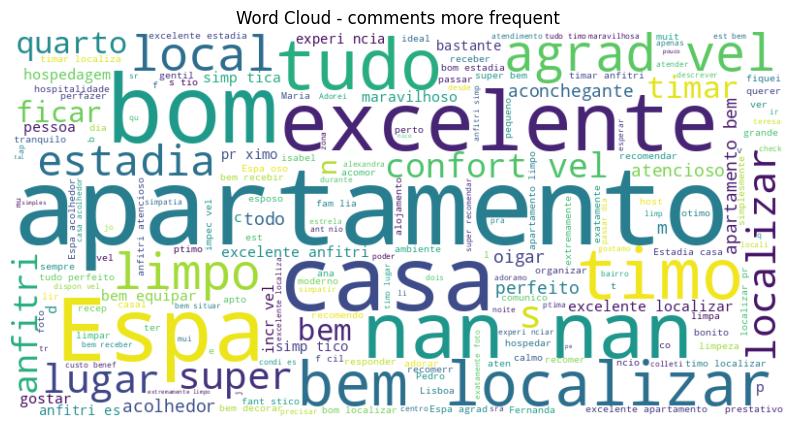

In [101]:
# Merge all the comments
all_comments = ' '.join(merged_df_pt['comments'])

# Create the Wordcloud
wordcloud_en = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

# Show the wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_en, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - comments more frequent')
plt.show()

## TF - IDF, Train and Evaluation of Estimators

In [102]:
def create_target(df):
    # Concatenate text columns into a single column
    df['Concatenated_Text'] = df['description'] + ' ' + df['host_about'] + ' ' + df['comments']

    #separate features and taget
    X = df['Concatenated_Text'].astype(str)
    y = df['unlisted'].astype(int)

    return X, y

In [104]:
def custom_fit_evaluate(X,y,estimator):
    tfidf = TfidfVectorizer()
    precision_avg = []
    recall_avg = []
    f1_avg = []
    accuracy_avg = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    for train_index, test_index in skf.split(X, y):
        x_train, x_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]


        x_train_tfidf = tfidf.fit_transform(x_train)
        x_val_tfidf = tfidf.transform(x_val)

        estimator.fit(x_train_tfidf,y_train)

        y_pred = estimator.predict(x_val_tfidf)

        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        accuracy = accuracy_score(y_val, y_pred)


        precision_avg.append(precision)
        recall_avg.append(recall)
        f1_avg.append(f1)
        accuracy_avg.append(accuracy)

    precision_avg = statistics.mean(precision_avg)
    recall_avg = statistics.mean(recall_avg)
    f1_avg = statistics.mean(f1_avg)
    accuracy_avg = statistics.mean(accuracy_avg)

    classes = np.unique(np.concatenate((y_val, y_pred)))

    # Create a confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.xticks(np.arange(len(classes)) + 0.5, classes)
    plt.yticks(np.arange(len(classes)) + 0.5, classes)
    plt.show()

    return precision_avg, recall_avg, f1_avg, accuracy_avg

## English

In [105]:
X_eng, y_eng = create_target(merged_df_english)

In [106]:
rf_classifier_eng = RandomForestClassifier(random_state=42)

In [110]:
mlp_eng = MLPClassifier(random_state=42)


In [123]:
lr_eng = LogisticRegression()

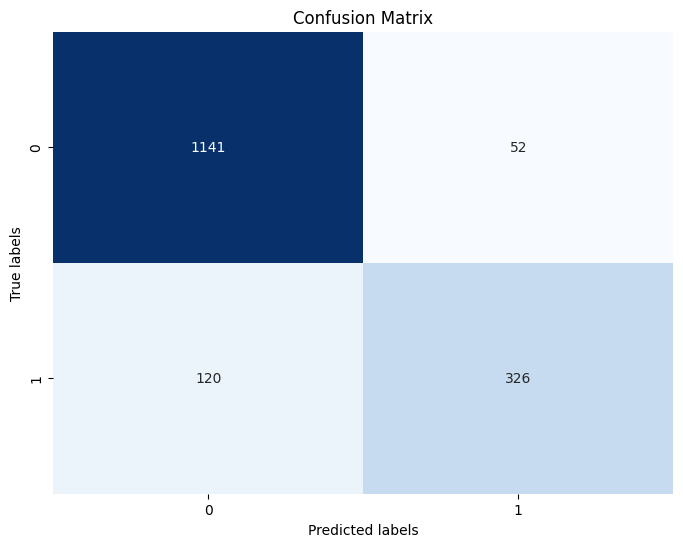

(0.8484754895490219,
 0.7057844524031661,
 0.7702971565887448,
 0.8854601258947306)

In [112]:
custom_fit_evaluate(X_eng, y_eng, rf_classifier_eng)

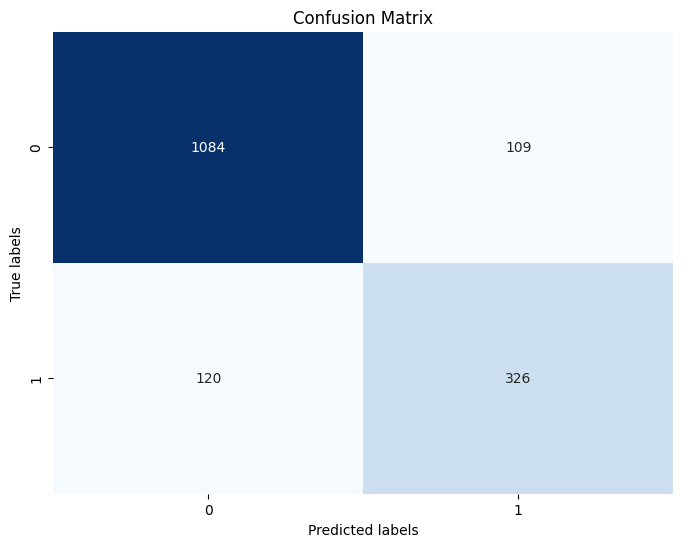

(0.7540107671708765,
 0.7281668522587053,
 0.7407687890949668,
 0.8611856575246656)

In [113]:
custom_fit_evaluate(X_eng, y_eng, mlp_eng)

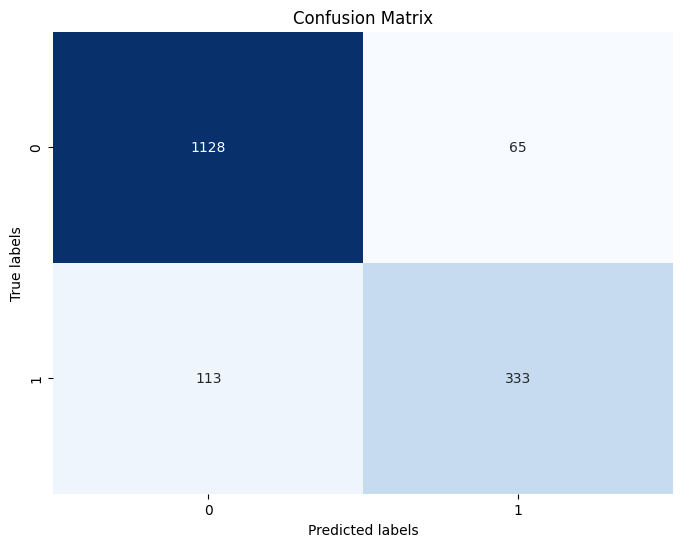

(0.8297638095106632,
 0.7178780309186304,
 0.7696875366030377,
 0.8830203574457953)

In [121]:
custom_fit_evaluate(X_eng, y_eng, lr_eng)

In [125]:
tfidf_eng = TfidfVectorizer()
x_train_tfidf_eng = tfidf_eng.fit_transform(X_eng)

In [126]:
rf_classifier_eng.fit(x_train_tfidf_eng, y_eng)

RandomForestClassifier(random_state=42)

In [127]:
mlp_eng.fit(x_train_tfidf_eng, y_eng)

MLPClassifier(random_state=42)

In [128]:
lr_eng.fit(x_train_tfidf_eng, y_eng)

LogisticRegression()

In [129]:
with open('/content/drive/MyDrive/Uni/Text Mining/tfidf_vectorizer_eng.pkl', 'wb') as file:
    pickle.dump(tfidf_eng, file)

In [130]:

joblib.dump(rf_classifier_eng, "/content/drive/MyDrive/Uni/Text Mining/rf_classifier_eng.joblib")
joblib.dump(mlp_eng, "/content/drive/MyDrive/Uni/Text Mining/mlp_eng.joblib")
joblib.dump(lr_eng, "/content/drive/MyDrive/Uni/Text Mining/lr_eng.joblib")

['/content/drive/MyDrive/Uni/Text Mining/lr_eng.joblib']

## French

In [131]:
X_fr, y_fr = create_target(merged_df_french)

In [132]:
rf_classifier_fr = RandomForestClassifier(random_state=42)

In [133]:
mlp_fr = MLPClassifier(random_state=42)

In [134]:
lr_fr = LogisticRegression()

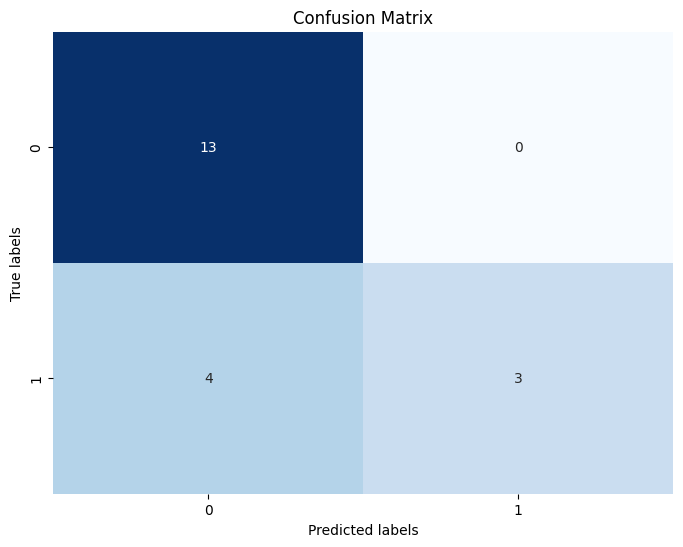

(0.86, 0.3678571428571428, 0.48767676767676765, 0.76)

In [135]:
custom_fit_evaluate(X_fr, y_fr, rf_classifier_fr)

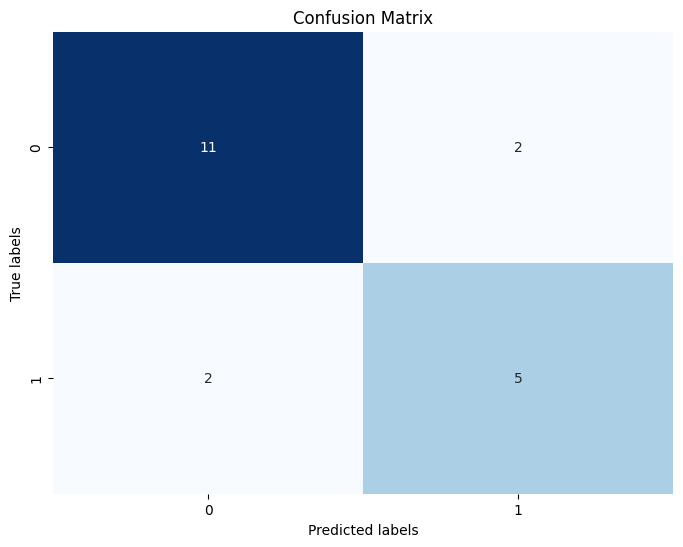

(0.7628571428571429,
 0.5107142857142857,
 0.5949783549783549,
 0.7790476190476191)

In [136]:
custom_fit_evaluate(X_fr, y_fr, mlp_fr)

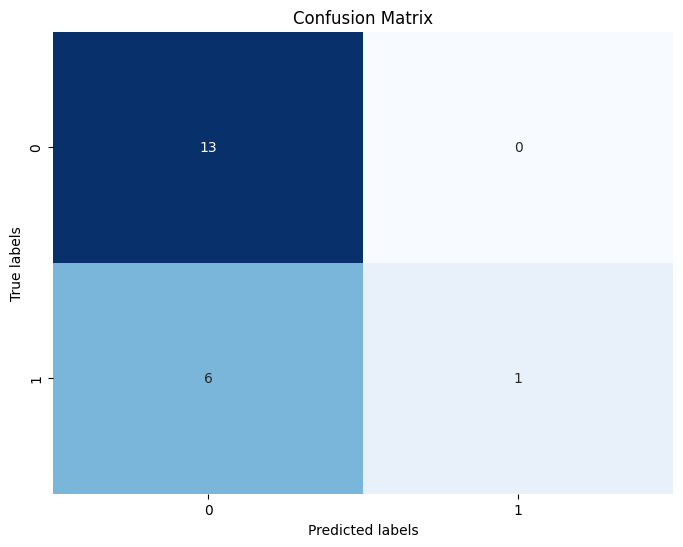

(0.8, 0.25357142857142856, 0.3598989898989899, 0.74)

In [137]:
custom_fit_evaluate(X_fr, y_fr, lr_fr)

In [138]:
tfidf_fr = TfidfVectorizer()
x_train_tfidf_fr = tfidf_fr.fit_transform(X_fr)

In [139]:
rf_classifier_fr.fit(x_train_tfidf_fr, y_fr)

RandomForestClassifier(random_state=42)

In [140]:
mlp_fr.fit(x_train_tfidf_fr, y_fr)

MLPClassifier(random_state=42)

In [141]:
lr_fr.fit(x_train_tfidf_fr, y_fr)

LogisticRegression()

In [142]:
with open('/content/drive/MyDrive/Uni/Text Mining/tfidf_vectorizer_fr.pkl', 'wb') as file:
    pickle.dump(tfidf_fr, file)

In [143]:
joblib.dump(rf_classifier_fr, "/content/drive/MyDrive/Uni/Text Mining/rf_classifier_fr.joblib")
joblib.dump(mlp_fr, "/content/drive/MyDrive/Uni/Text Mining/mlp_fr.joblib")
joblib.dump(lr_fr, "/content/drive/MyDrive/Uni/Text Mining/lr_fr.joblib")

['/content/drive/MyDrive/Uni/Text Mining/lr_fr.joblib']

## Portuguese

In [144]:
X_pt, y_pt = create_target(merged_df_pt)

In [145]:
rf_classifier_pt = RandomForestClassifier(random_state=42)

In [146]:
mlp_pt = MLPClassifier(random_state=42)

In [173]:
lr_pt = LogisticRegression()

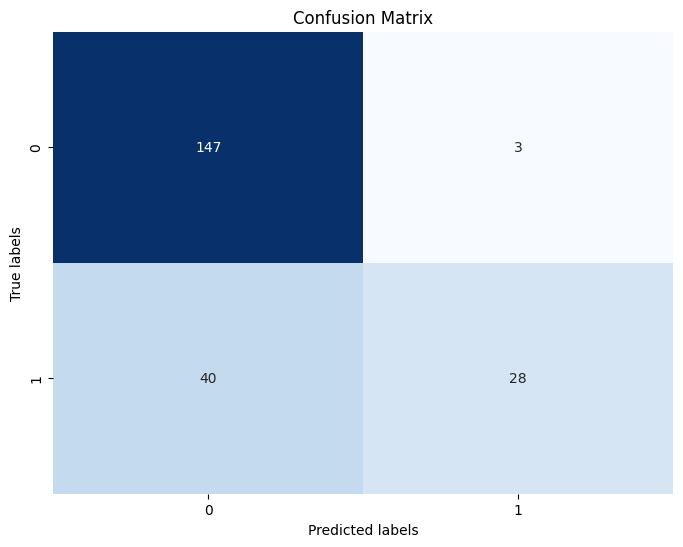

(0.8707404976704887,
 0.40294117647058825,
 0.5490572336484774,
 0.7952536550626282)

In [148]:
custom_fit_evaluate(X_pt, y_pt, rf_classifier_pt)

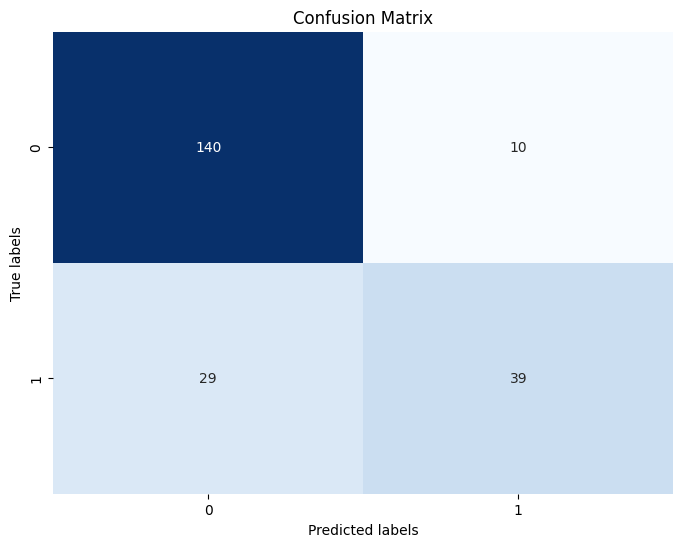

(0.7411283375010083,
 0.5294117647058824,
 0.6168074174688478,
 0.7952704117967409)

In [149]:
custom_fit_evaluate(X_pt, y_pt, mlp_pt)

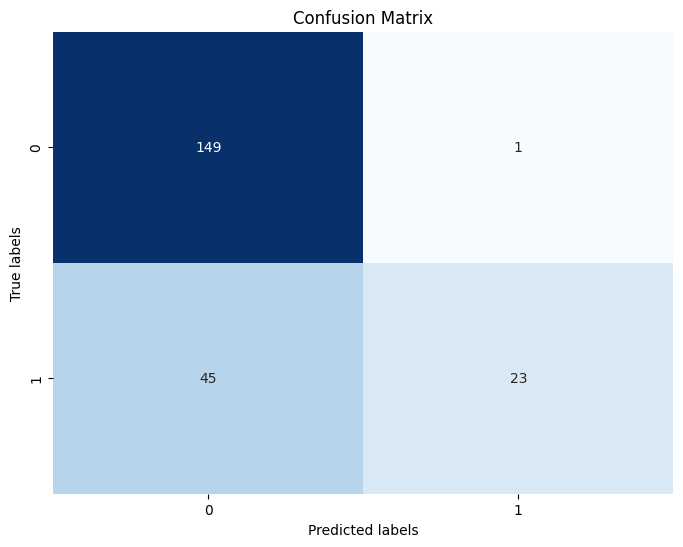

(0.9220899470899471,
 0.3235294117647059,
 0.4769669141547967,
 0.7806292153659252)

In [150]:
custom_fit_evaluate(X_pt, y_pt, lr_pt)

In [151]:
tfidf_pt = TfidfVectorizer()
x_train_tfidf_pt = tfidf_pt.fit_transform(X_pt)

In [152]:
rf_classifier_pt.fit(x_train_tfidf_pt, y_pt)

RandomForestClassifier(random_state=42)

In [153]:
mlp_pt.fit(x_train_tfidf_pt, y_pt)

MLPClassifier(random_state=42)

In [154]:
lr_pt.fit(x_train_tfidf_pt, y_pt)

LogisticRegression()

In [155]:
with open('/content/drive/MyDrive/Uni/Text Mining/tfidf_vectorizer_pt.pkl', 'wb') as file:
    pickle.dump(tfidf_pt, file)

In [156]:
joblib.dump(rf_classifier_pt, "/content/drive/MyDrive/Uni/Text Mining/rf_classifier_pt.joblib")
joblib.dump(mlp_pt, "/content/drive/MyDrive/Uni/Text Mining/mlp_pt.joblib")
joblib.dump(lr_pt, "/content/drive/MyDrive/Uni/Text Mining/lr_pt.joblib")

['/content/drive/MyDrive/Uni/Text Mining/lr_pt.joblib']

## Prediction

In [157]:
def translate_to_eng(text):
    key = "4aacdafc18474eb0accce6d24349ac62"
    endpoint = "https://api.cognitive.microsofttranslator.com"

    location = "westeurope"

    path = '/translate'
    constructed_url = endpoint + path

    params = {
        'api-version': '3.0',
        'to': 'en'
    }

    headers = {
        'Ocp-Apim-Subscription-Key': key,
        'Ocp-Apim-Subscription-Region': location,
        'Content-type': 'application/json',
        'X-ClientTraceId': str(uuid.uuid4())
    }

    body = [{
        'text': text
    }]

    request = requests.post(constructed_url, params=params, headers=headers, json=body)
    response = request.json()

    return response[0]["translations"][0]["text"]

In [158]:
def create_feature_row(row):
    description = row[1]
    host_about = row[2]
    comments = row[3]

    # Concatenate text columns into a single column
    concatenated_text = str(description) + ' ' + str(host_about) + ' ' + str(comments)

    return concatenated_text

In [159]:
def merge_test_df(df, df_review):
    grouped_reviews = df_review.groupby('index')['comments'].apply(lambda x: ''.join(str(x))).reset_index()
    merged_df = pd.merge(df, grouped_reviews, on='index', how='left')
    merged_df = merged_df[["index",	"description", "host_about", "comments"]]

    return merged_df

In [166]:
merged_test_df = merge_test_df(airbnb_df_test, airbnb_df_test_reviews)

In [167]:
merged_test_df

,index,description,host_about,comments
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",0 Thank you very much Antonio ! All has b...
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...,"125 This is a beautiful, bright apartment i..."
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ...",NaN
3,4,Charming Apartment Close to the Bay of Cascais...,:),136 Claudia was a great host. She met us a...
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...,153 La maison est exactement comme sur les ...
...,...,...,...,...
1384,1385,O melhor ponto de partida para descobrir Lisbo...,I work in Hospitality and I love traveling._x0...,NaN
1385,1386,Casa de Baixo is a cozy and comfortable apartm...,"Visit us, stay with us and discover the most b...",80490 Bonnes prestations et bien situé.<br/...
1386,1387,Beautiful and peaceful apartment with a superb...,"Nice, well travelled, educated, cult, cosmopol...","80827 Tiago é muito simpático e disponível,..."
1387,1388,The apartment in Lisbon has capacity for 2 pe...,We are Feels Like Home Holiday Rentals.\nA com...,80875 Unfortunately not a pleasant experien...


In [168]:
def prediction(row):
    columns_to_apply = ['description', 'host_about', 'comments']
    lang_desc = detect_language(str(row[1]))
    lang_host = detect_language(str(row[2]))
    lang_review = detect_language(str(row[3]))

    if (lang_desc == "en") & (lang_host == "en") & (lang_review == "en"):
        row = preprocessing_eng(row=row,
                                tokenize=True,
                                stop=True,
                                lemmatize = True,
                                stemmertize = False
                                )

        row = create_feature_row(row)

        with open('/content/drive/MyDrive/Uni/Text Mining/tfidf_vectorizer_eng.pkl', 'rb') as file:
            tfidf_vectorizer_eng = pickle.load(file)

        row_list = [row]
        row = tfidf_vectorizer_eng.transform(row_list)

        loaded_rf_eng = joblib.load("/content/drive/MyDrive/Uni/Text Mining/rf_classifier_eng.joblib")

        return int(loaded_rf_eng.predict(row)[0])

    elif (lang_desc == "fr") & (lang_host == "fr") & (lang_review == "fr"):
        row = preprocessing_fr(row=row,
                                tokenize=True,
                                stop=True,
                                lemmatize = True,
                                stemmertize = False
                                )

        row = create_feature_row(row)

        with open('/content/drive/MyDrive/Uni/Text Mining/tfidf_vectorizer_fr.pkl', 'rb') as file:
            tfidf_vectorizer_fr = pickle.load(file)

        row_list = [row]
        row = tfidf_vectorizer_fr.transform(row_list)

        loaded_rf_fr = joblib.load("/content/drive/MyDrive/Uni/Text Mining/rf_classifier_fr.joblib")

        return int(loaded_rf_fr.predict(row)[0])

    elif (lang_desc == "pt") & (lang_host == "pt") & (lang_review == "pt"):
        row = preprocessing_pt(row=row,
                                tokenize=True,
                                stop=True,
                                lemmatize = True,
                                stemmertize = False
                                )

        row = create_feature_row(row)

        with open('/content/drive/MyDrive/Uni/Text Mining/tfidf_vectorizer_pt.pkl', 'rb') as file:
            tfidf_vectorizer_pt = pickle.load(file)

        row_list = [row]
        row = tfidf_vectorizer_pt.transform(row_list)

        loaded_rf_pt = joblib.load("/content/drive/MyDrive/Uni/Text Mining/rf_classifier_pt.joblib")

        return int(loaded_rf_pt.predict(row)[0])
    else:
        loaded_rf_eng = joblib.load("/content/drive/MyDrive/Uni/Text Mining/rf_classifier_eng.joblib")
        row = create_feature_row(row)
        row = translate_to_eng(row)
        row = preprocessing_eng(row=row,
                                tokenize=True,
                                stop=True,
                                lemmatize = True,
                                stemmertize = False
                                )

        with open('/content/drive/MyDrive/Uni/Text Mining/tfidf_vectorizer_eng.pkl', 'rb') as file:
            tfidf_vectorizer_eng = pickle.load(file)

        row = tfidf_vectorizer_eng.transform(row)

        return int(loaded_rf_eng.predict(row)[0])

In [ ]:
merged_test_df["prediction"] = merged_test_df.apply(lambda row: prediction(row), axis=1)

In [170]:
merged_test_df["prediction"].value_counts(dropna=False)

0    1384
1       5
Name: prediction, dtype: int64

In [171]:
merged_test_df

,index,description,host_about,comments,prediction
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",0 Thank you very much Antonio ! All has b...,0
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...,"125 This is a beautiful, bright apartment i...",0
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ...",NaN,0
3,4,Charming Apartment Close to the Bay of Cascais...,:),136 Claudia was a great host. She met us a...,0
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...,153 La maison est exactement comme sur les ...,0
...,...,...,...,...,...
1384,1385,O melhor ponto de partida para descobrir Lisbo...,I work in Hospitality and I love traveling._x0...,NaN,0
1385,1386,Casa de Baixo is a cozy and comfortable apartm...,"Visit us, stay with us and discover the most b...",80490 Bonnes prestations et bien situé.<br/...,0
1386,1387,Beautiful and peaceful apartment with a superb...,"Nice, well travelled, educated, cult, cosmopol...","80827 Tiago é muito simpático e disponível,...",0
1387,1388,The apartment in Lisbon has capacity for 2 pe...,We are Feels Like Home Holiday Rentals.\nA com...,80875 Unfortunately not a pleasant experien...,0


In [172]:
merged_test_df.to_csv("/content/drive/MyDrive/Uni/Text Mining/prediction_approach_1.csv")

# Second Approach 2.1 - Glove Embedding with subsample of data (reaching resource limits)

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('<[^>]+>', ' ', text)
    text = re.sub("[^a-zA-Z]", " ", text)

    return text

## Load previous detected and stored Dataset

In [ ]:
#df_train_reviews = pd.read_csv("/content/drive/MyDrive/Uni/Text Mining/2.data_detected/airbnb_df_train__reviews_detected.csv").drop("Unnamed: 0", axis=1)

In [ ]:
#df_train = pd.read_csv("/content/drive/MyDrive/Uni/Text Mining/2.data_detected/airbnb_df_train_detected.csv").drop("Unnamed: 0", axis=1)

## Merge the two train Dataframes

In [ ]:
df_merged = pd.merge(airbnb_df_train, airbnb_df_train_reviews on="index", how="left")

In [ ]:
def prepare_df(df):
    grouped_df = df.groupby('index').agg({
        'description': 'first',
        'host_about': 'first',
        'comments': lambda x: ' '.join(x.astype(str).values),
        'lang_comments': lambda x: ' '.join(x.astype(str).values),
        "unlisted" : "first"
    }).reset_index()

    return grouped_df

## Grouping and Preprocessing of the Dataframes

In [ ]:
grouped_df = prepare_df(df_merged)

In [ ]:
columns_to_clean = ['description', 'host_about', 'comments']

grouped_df[columns_to_clean] = grouped_df[columns_to_clean].applymap(clean_text)

In [ ]:
# Load the DataFrame
df = grouped_df.sample(800, random_state=1)

# Filter out rows with missing values in necessary columns
df = df.dropna(subset=['description', 'host_about', 'comments'])

# Extract the necessary columns
text_data = df['description'] + ' ' + df['host_about'] + ' ' + df['comments']
labels = df['unlisted']

# Split the data into train and test sets
text_train, text_test, labels_train, labels_test = train_test_split(text_data, labels, test_size=0.2, random_state=42)

# Tokenize the text and convert it into sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)

vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max([len(sentence.split()) for sentence in text_train])

sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_test = tokenizer.texts_to_sequences(text_test)

In [ ]:
# Pad sequences to have the same length
padded_train = pad_sequences(sequences_train, maxlen=max_sequence_length, padding='post')
padded_test = pad_sequences(sequences_test, maxlen=max_sequence_length, padding='post')

## Load Glove Word Embeddings

In [ ]:
# Load pre-trained GloVe word embeddings
embeddings_index = {}
with open('/content/drive/MyDrive/glove.6B/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedded_train = np.array([embedding_matrix[word] for word in padded_train])
embedded_test = np.array([embedding_matrix[word] for word in padded_test])

In [ ]:
embedded_train_flat = embedded_train.reshape(embedded_train.shape[0], -1)
embedded_test_flat = embedded_test.reshape(embedded_test.shape[0], -1)

## Fit and Evaluate the Models

In [ ]:
def custom_fit_evaluate(classifier, X_train, y_train, X_val, y_val):
    # Train the Random Forest classifier
    classifier = RandomForestClassifier(random_state=42)
    classifier.fit(X_train, y_train)

    # Predict on the test set
    predictions = classifier.predict(X_val)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return predictions


In [ ]:
rf_classifier_2_1 = RandomForestClassifier(random_state=42)

In [ ]:
rf_classifier_2_1_pred = custom_fit_evaluate(rf_classifier_2_1, embedded_train_flat, labels_train, embedded_test_flat, labels_test)

In [ ]:
mlp_2_1 = MLPClassifier(random_state=42)

In [174]:
mlp_2_1_pred = custom_fit_evaluate(mlp_2_1, embedded_train_flat, labels_train, embedded_test_flat, labels_test)

NameError: ignored

In [ ]:
lr_2_1 = LogisticRegression()

In [ ]:
lstm_2_1_pred = custom_fit_evaluate(lr_2_1, embedded_train_flat, labels_train, embedded_test_flat, labels_test)

In [ ]:
def plot_confusion_matrix(labels, predictions):
    classes = np.unique(np.concatenate((labels, predictions)))

    # Create a confusion matrix
    cm = confusion_matrix(labels, predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.xticks(np.arange(len(classes)) + 0.5, classes)
    plt.yticks(np.arange(len(classes)) + 0.5, classes)
    plt.show()

In [ ]:
plot_confusion_matrix(labels_test, rf_classifier_2_1_pred)

In [ ]:
plot_confusion_matrix(labels_test, mlp_2_1_pred)

In [ ]:
plot_confusion_matrix(labels_test, lstm_2_1_pred)

In [ ]:
del embedded_train_flat
del embedded_test_flat

## Loading Test Dataframe and preparing them for the Prediction

In [ ]:
df_test = pd.read_excel("/content/drive/MyDrive/Uni/Text Mining/test.xlsx")
df_test_reviews = pd.read_excel("/content/drive/MyDrive/Uni/Text Mining/test_reviews.xlsx")

In [ ]:
test_df = pd.merge(df_test,df_test_reviews, on="index", how="left")

In [ ]:
    test_df = test_df.groupby('index').agg({
        'description': 'first',
        'host_about': 'first',
        'comments': lambda x: ' '.join(x.astype(str).values),
    }).reset_index()

## Prediction

In [ ]:
def predict_row(classifier, row):
    # Clean the text in the necessary columns
    cleaned_text = row[["description", "host_about", "comments"]].apply(clean_text)

    # Combine the necessary columns into a single text
    text_data = cleaned_text['description'] + ' ' + cleaned_text['host_about'] + ' ' + cleaned_text['comments']

    # Tokenize and convert the text data into sequences
    sequences = tokenizer.texts_to_sequences([text_data])

    # Pad the sequences to have the same length as the training data
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

    # Create word embedding feature vectors
    embedded_data = np.array([embedding_matrix[word] for word in padded_sequences])
    embedded_data_flat = embedded_data.reshape(embedded_data.shape[0], -1)

    # Predict on the data
    prediction = classifier.predict(embedded_data_flat)

    return prediction[0]  # Assuming you want to return a single prediction

In [ ]:
test_df['predictions'] = test_df.apply(lambda row: predict_row(rf_classifier_2_1, row), axis=1)

In [ ]:
test_df['predictions'].value_counts()

In [ ]:
test_df.to_csv("./6.Predictions/prediction_approach_2_1.csv")

# Second Approach 2.2 - Glove Embedding batch wise to avoid resource limitations

## Load previous detected and stored Dataset

In [ ]:
df_train_reviews = pd.read_csv("/content/drive/MyDrive/Uni/Text Mining/2.data_detected/airbnb_df_train__reviews_detected.csv").drop("Unnamed: 0", axis=1)

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Uni/Text Mining/2.data_detected/airbnb_df_train_detected.csv").drop("Unnamed: 0", axis=1)

## Merge the two Dataframes

In [ ]:
df_merged = pd.merge(df_train,df_train_reviews, on="index", how="left")

In [ ]:
grouped_df = prepare_df(df_merged)

In [ ]:
columns_to_clean = ['description', 'host_about', 'comments']

grouped_df[columns_to_clean] = grouped_df[columns_to_clean].applymap(clean_text)

## Preprocess the data

In [ ]:
# Load the DataFrame
df = grouped_df

# Filter out rows with missing values in necessary columns
df = df.dropna(subset=['description', 'host_about', 'comments'])

# Extract the necessary columns
text_data = df['description'] + ' ' + df['host_about'] + ' ' + df['comments']
labels = df['unlisted']

# Split the data into train and test sets
text_train, text_test, labels_train, labels_test = train_test_split(text_data, labels, test_size=0.2, random_state=42)

# Tokenize the text and convert it into sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)

vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max([len(sentence.split()) for sentence in text_train])

sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_test = tokenizer.texts_to_sequences(text_test)

## Load Glove word embedding

In [ ]:
# Load pre-trained GloVe word embeddings
embeddings_index = {}
with open('/content/drive/MyDrive/glove.6B/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [ ]:
batch_size = 100

## Fit and Evaluate the Models

In [ ]:
rf_classifier_2_2 = RandomForestClassifier(random_state=42, n_estimators=300, min_samples_split=32, min_samples_leaf=16, max_depth=4, warm_start=True)

In [ ]:
mlp_2_2 = create_mlp(input_dim=max_sequence_length, output_dim=1, embedding_dim=50, hidden_units=64)
mlp_2_2.summary()
mlp_2_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

In [ ]:
lstm_2_2 = create_lstm(input_dim=max_sequence_length, output_dim=1, embedding_dim=50, hidden_units=64)
lstm_2_2.summary()
lstm_2_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

In [ ]:

def fit_model(classifier, sequences_train, labels_train, batch_size):
    # Get the total number of samples
    total_samples = len(sequences_train)


    # Iterate over the data in batches
    for i in range(0, total_samples, batch_size):
        # Get the current batch
        batch_start = i
        batch_end = min(i + batch_size, total_samples)
        batch_sequences_train = sequences_train[batch_start:batch_end]

        # Pad sequences to have the same length
        padded_train = pad_sequences(batch_sequences_train, maxlen=max_sequence_length, padding='post')
        # Create word embedding feature vectors
        embedded_train = np.array([embedding_matrix[word] for word in padded_train])
        embedded_train_flat = embedded_train.reshape(embedded_train.shape[0], -1)

        classifier.fit(embedded_train_flat, labels_train[batch_start:batch_end])

In [ ]:
fit_model(rf_classifier_2_2, sequences_train, labels_train, batch_size)

In [ ]:
fit_model(mlp_2_2, sequences_train, labels_train, batch_size)

In [ ]:
fit_model(lstm_2_2, sequences_train, labels_train, batch_size)

In [ ]:
def evaluate_model(classifier, sequences_test, labels_test, batch_size):
    total_samples = len(sequences_test)

    # Initialize an empty array to store the predictions
    predictions = np.array([])

    # Iterate over the data in batches
    for i in range(0, total_samples, batch_size):
        # Get the current batch
        batch_start = i
        batch_end = min(i + batch_size, total_samples)
        batch_sequences_test = sequences_test[batch_start:batch_end]
        padded_test = pad_sequences(batch_sequences_test, maxlen=max_sequence_length, padding='post')
        embedded_test = np.array([embedding_matrix[word] for word in padded_test])
        embedded_test_flat = embedded_test.reshape(embedded_test.shape[0], -1)
        batch_predictions = classifier.predict(embedded_test_flat)

        predictions = np.concatenate((predictions, batch_predictions))

    accuracy = accuracy_score(labels_test, predictions)
    precision = precision_score(labels_test, predictions)
    recall = recall_score(labels_test, predictions)
    f1 = f1_score(labels_test, predictions)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return predictions

In [ ]:
rf_classifier_2_2_pred = evaluate_model(rf_classifier_2_2, sequences_test, labels_test, batch_size)

In [ ]:
mlp_2_2_pred = evaluate_model(mlp_2_2, sequences_test, labels_test, batch_size)

In [ ]:
lstm_2_2_pred = evaluate_model(lstm_2_2, sequences_test, labels_test, batch_size)

In [ ]:
plot_confusion_matrix(labels_test, rf_classifier_2_2_pred)

In [ ]:
plot_confusion_matrix(labels_test, mlp_2_2_pred)

In [ ]:
plot_confusion_matrix(labels_test, lstm_2_2_pred)

## Loading Test Dataframe and preparing for Prediction

In [ ]:
df_test = pd.read_excel("/content/drive/MyDrive/Uni/Text Mining/test.xlsx")
df_test_reviews = pd.read_excel("/content/drive/MyDrive/Uni/Text Mining/test_reviews.xlsx")

In [ ]:
test_df = pd.merge(df_test,df_test_reviews, on="index", how="left")

In [ ]:
    test_df = test_df.groupby('index').agg({
        'description': 'first',
        'host_about': 'first',
        'comments': lambda x: ' '.join(x.astype(str).values),
    }).reset_index()

## Prediction

In [ ]:
def predict_row(classifier, row):
    # Clean the text in the necessary columns
    cleaned_text = row[["description", "host_about", "comments"]].apply(clean_text)

    # Combine the necessary columns into a single text
    text_data = cleaned_text['description'] + ' ' + cleaned_text['host_about'] + ' ' + cleaned_text['comments']

    # Tokenize and convert the text data into sequences
    sequences = tokenizer.texts_to_sequences([text_data])

    # Pad the sequences to have the same length as the training data
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

    # Create word embedding feature vectors
    embedded_data = np.array([embedding_matrix[word] for word in padded_sequences])
    embedded_data_flat = embedded_data.reshape(embedded_data.shape[0], -1)

    # Predict on the data
    prediction = classifier.predict(embedded_data_flat)

    return prediction[0]  # Assuming you want to return a single prediction

In [ ]:
test_df['predictions'] = test_df.apply(lambda row: predict_row(rf_classifier_2_2, row), axis=1)

In [ ]:
test_df['predictions'].value_counts()

# Third Approach - Transformer based Embedding